# Set up the environment

Before running the notebook, please ensure the necessary packages are installed in the kernel environment where this notebook is running.
**Required packages:** See `requirements.txt`. Run `pip install -r requirements.txt` before executing this notebook. Alternatively, uncomment and
run the cell below to install packages manually. 


In [ ]:
""" %pip install python-dateutil
%pip install pandas
%pip install numpy
%pip install seaborn
%pip install matplotlib
%pip install earthengine-api --upgrade
%pip install geemap
%pip install xarray """

In [131]:
from dateutil.relativedelta import relativedelta
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import ee
import geemap
import xarray as xr

# Authenticate and Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project= "ee-christopherharrellgis") # Replace with your own ee cloud project account

#Initialize Map
Map = geemap.Map()

### Data Imports

In [132]:
# SOC samples table loaded from earth engine asset
soc_sample_points = ee.FeatureCollection("users/christopherharrellgis/soc_samples")

# Buffer sample points by 10km and return bounds
study_area = soc_sample_points.geometry().bounds().buffer(10000).bounds()

# Harmonized Sentinel-2 SR and Cloud Score
s2 = ee.ImageCollection('COPERNICUS/S2_SR')
s2CloudScore = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

# DEM
dem = ee.ImageCollection('COPERNICUS/DEM/GLO30')

# CHIRPS Daily
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')

##### Define Global Variables

In [164]:
# Start/End Dates
p1_start_date = "2022-03-01"
p1_end_date = "2023-02-28"
 
p2_start_date = "2023-03-01"
p2_end_date = "2024-02-29"

# Sentinel-2
S2_QA_BAND = "cs_cdf"
S2_CLEAR_THRESHOLD = 0.60
S2_SCALE_FACTOR = 0.0001

In [134]:
def temporal_filter(imageCollection, start_date, end_date):
    """ Filters an ImageCollection by start and end dates """
    return imageCollection.filterDate(start_date, end_date)

def spatial_filter(imageCollection, region):
    """ Filters an ImageCollection by region """
    return imageCollection.filterBounds(region)

def clip_to_roi(image):
    return image.clip(study_area)

def temporal_reducer(col):
    """ Reduces an ImageCollection over time by computing the mean, 10th and 90th percentiles, and standard deviation for each pixel. """
    reducer = ee.Reducer.mean() \
    .combine(ee.Reducer.percentile([10, 90]), sharedInputs = True) \
    .combine(ee.Reducer.stdDev(), sharedInputs = True)
    return col.reduce(reducer) 


#### Sentinel-2 processing

In [135]:
def s2_cloud_mask(image):
    """Applies a cloud mask based on the QA band using a threshold to identify clear pixels."""
    return image.select(S2_QA_BAND).gte(S2_CLEAR_THRESHOLD)

def calc_ndvi_s2(image):
    """Calculates the Normalized Difference Vegetation Index (NDVI) from NIR and Red bands."""
    return image.normalizedDifference(['B8', 'B4']).rename('NDVI')

def calc_evi_s2(image):
    """Calculates the Enhanced Vegetation Index (EVI) from an image and returns it as a single-band image named 'EVI'."""
    return image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }
    ).rename('EVI')

def calc_nirv_s2(image):
    """ Calculates the NIRv from an image and returns it as a single-band image named 'NIRv'. """
    ndvi = calc_ndvi_s2(image)
    nir = image.select('B8')
    return nir.multiply(ndvi).rename('NIRv')

def calc_lai_s2(image):
    """Calculates the Leaf-Area-Index (LAI) for an image and returns its as a single-band image named 'LAI'."""
    evi = calc_evi_s2(image)
    return evi.expression('3.618 * EVI - 0.118', {'EVI': evi}).rename('LAI')

def calc_veg_indices_s2(image):
    """Adds multiple vegetation and water indices (NDVI, EVI, NDWI, MNDWI, SAVI) as bands to the image."""
    return image.addBands(
        [calc_ndvi_s2(image), calc_evi_s2(image), calc_nirv_s2(image), calc_lai_s2(image)]
    )

def process_s2_image(image):
    """Processes Sentinel-2 SR image to apply cloud masking, scale, and add NDVI, EVI, NIRv, and LAI."""
    original = image
    mask = s2_cloud_mask(image)
    image = image.select([
        "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B11", "B12"]
    ).multiply(S2_SCALE_FACTOR)

    indices = calc_veg_indices_s2(image).updateMask(mask)
    return indices.copyProperties(original, ["system:time_start"])

def link_s2_collections(col1, col2):
    """Links a secondary collection (e.g., QA) to a primary Sentinel-2 collection by matching and attaching specified bands."""
    linked_collection = col1.linkCollection(col2, [S2_QA_BAND])
    return linked_collection

#### CHIRPS Precip Processing

In [136]:
def mean_daily_precip_series(start_date, end_date):
    """ Returns a time series of daily precipitation means using CHIRPS data. """
    filtered = chirps.filterDate(start_date, end_date)
    def extract_mean(img):
        stat = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=study_area,
            scale=5000,
            maxPixels=1e13
        )
        return ee.Feature(None, {'date': img.date().format('YYYY-MM-dd'), 'precip': stat.get('precipitation')})
    return ee.FeatureCollection(filtered.map(extract_mean))

def plot_mean_daily_precip(feature_collection):
    """ Plots mean daily precipitation from a FEatureCollection of summary statistics. """
    features = feature_collection.getInfo()['features']
    data = [{'date': f['properties']['date'], 'precip': f['properties']['precip']} for f in features]

    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'])
    df['precip'] = pd.to_numeric(df['precip'], errors='coerce')

    years = sorted(df['date'].dt.year.unique())

    plt.figure(figsize=(14, 5))
    sns.lineplot(data=df, x='date', y='precip')

    plt.axvline(pd.to_datetime(f'{years[0]}-03-15'), color='green', linestyle='--', label='Long Rains')
    plt.axvline(pd.to_datetime(f'{years[0]}-06-01'), color='green', linestyle='--')

    plt.axvline(pd.to_datetime(f'{years[0]}-10-15'), color='blue', linestyle='--', label='Short Rains')
    plt.axvline(pd.to_datetime(f'{years[0]}-12-31'), color='blue', linestyle='--')

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    plt.title('Daily Mean Precipitation (CHIRPS)')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Convert to pandas DataFrames
def fc_to_df(fc, period_label):
    features = fc.getInfo()['features']
    data = [{'date': f['properties']['date'], 'precip': f['properties']['precip']} for f in features]
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'])
    df['precip'] = pd.to_numeric(df['precip'], errors='coerce')
    df['period'] = period_label
    return df
    

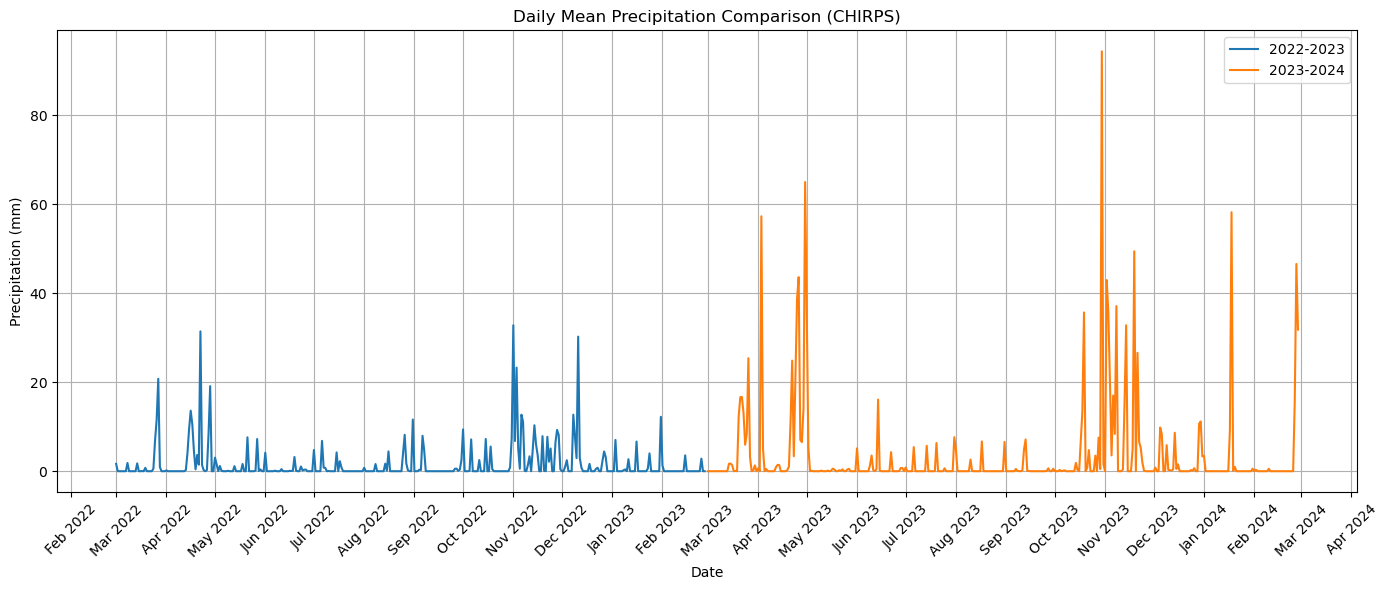

In [137]:

# Generate mean daily precipitation series for p1 and p2
daily_precip_fc_p1 = mean_daily_precip_series(p1_start_date, p1_end_date)
daily_precip_fc_p2 = mean_daily_precip_series(p2_start_date, p2_end_date)

# Convert precip series into pandas dataframe
df_p1 = fc_to_df(daily_precip_fc_p1, '2022-2023')
df_p2 = fc_to_df(daily_precip_fc_p2, '2023-2024')
df_all = pd.concat([df_p1, df_p2])

# Set up plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_all, x='date', y='precip', hue='period')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Format plot
plt.title('Daily Mean Precipitation Comparison (CHIRPS)')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Processing Remote Sensing Data

In [138]:
# Sentinel-2 SR
s2 = spatial_filter(s2, study_area)

# P1
s2_p1 = temporal_filter(s2, p1_start_date, p1_end_date)
s2_linked_p1 = link_s2_collections(s2_p1, s2CloudScore)
s2_processed_p1 = s2_linked_p1.map(process_s2_image)

s2_ndvi_p1 = s2_processed_p1.map(lambda img: img.clip(study_area)).select('NDVI')
s2_evi_p1 = s2_processed_p1.map(lambda img: img.clip(study_area)).select('EVI')
s2_nirv_p1 = s2_processed_p1.map(lambda img: img.clip(study_area)).select('NIRv')
s2_lai_p1 = s2_processed_p1.map(lambda img: img.clip(study_area)).select('LAI')

# P2
s2_p2 = temporal_filter(s2, p2_start_date, p2_end_date)
s2_linked_p2 = link_s2_collections(s2_p2, s2CloudScore)
s2_processed_p2 = s2_linked_p2.map(process_s2_image)

s2_ndvi_p2 = s2_processed_p2.map(lambda img: img.clip(study_area)).select('NDVI')
s2_evi_p2 = s2_processed_p2.map(lambda img: img.clip(study_area)).select('EVI')
s2_nirv_p2 = s2_processed_p2.map(lambda img: img.clip(study_area)).select('NIRv')
s2_lai_p2 = s2_processed_p2.map(lambda img: img.clip(study_area)).select('LAI')

# CHIRPS
chirps = spatial_filter(chirps, study_area)



In [139]:
def resample_monthly_mean(
    col,
    geometry = study_area,
    scale: float = 0.00027,
    crs: str = 'EPSG:4326',
) -> xr.Dataset:
    """
    Opens an Earth Engine-exported image collection and computes monthly mean composites.

    Returns:
        Monthly mean-resampled dataset or variable DataArray.
    """
    ds = xr.open_dataset(col, engine='ee', crs=crs, scale=scale, geometry=geometry)
    ds = ds.sortby('time')
    monthly_mean = ds.resample(time='M').mean('time')
    return monthly_mean

#### Generate plots of Vegetation Indices for P1 and P2

#### NDVI

In [141]:
p1_monthly_ndvi = resample_monthly_mean(s2_ndvi_p1)
#p1_monthly_ndvi.NDVI.plot(x='lon', y='lat', col='time', col_wrap=4, robust=True)

p2_monthly_ndvi = resample_monthly_mean(s2_ndvi_p2)
#p2_monthly_ndvi.NDVI.plot(x='lon', y='lat', col='time', col_wrap=4, robust=True)

#### EVI

In [ ]:
p1_monthly_evi = resample_monthly_mean(s2_evi_p1)
#p1_monthly_evi.EVI.plot(x='lon', y='lat', col='time', col_wrap=4, robust=True)

p2_monthly_evi = resample_monthly_mean(s2_evi_p2)
#p1_monthly_evi.EVI.plot(x='lon', y='lat', col='time', col_wrap=4, robust=True)

#### NIRv

In [ ]:
p1_monthly_nirv = resample_monthly_mean(s2_nirv_p1)
#p1_monthly_nirv.NIRv.plot(x='lon', y='lat', col='time', col_wrap=4, robust=True)

p2_monthly_nirv = resample_monthly_mean(s2_nirv_p2)
#p1_monthly_nirv.NIRv.plot(x='lon', y='lat', col='time', col_wrap=4, robust=True)

#### LAI

In [ ]:
p1_monthly_lai = resample_monthly_mean(s2_lai_p1)
#p1_monthly_lai.LAI.plot(x='lon', y='lat', col='time', col_wrap=4, robust=True)

p2_monthly_lai = resample_monthly_mean(s2_lai_p2)
#p1_monthly_lai.LAI.plot(x='lon', y='lat', col='time', col_wrap=4, robust=True)

In [142]:
def spatial_mean_timeseries(
    dataset: xr.Dataset,
    spatial_dims: list = ['lon', 'lat'],
) -> pd.DataFrame:
    """
    Computes the spatial mean of a resampled dataset and returns a time series DataFrame.
    """
    variable_name = list(dataset.data_vars)[0]
    timeseries = dataset[variable_name].mean(dim=spatial_dims)
    df = timeseries.to_dataframe(name=variable_name).reset_index()
    return df

In [ ]:
p1_ndvi_timeseries = spatial_mean_timeseries(p1_monthly_ndvi)
p1_evi_timeseries = spatial_mean_timeseries(p1_monthly_evi)
p1_nirv_timeseries = spatial_mean_timeseries(p1_monthly_nirv)
p1_lai_timeseries = spatial_mean_timeseries(p1_monthly_lai)

p2_ndvi_timeseries = spatial_mean_timeseries(p2_monthly_ndvi)
p2_evi_timeseries = spatial_mean_timeseries(p2_monthly_evi)
p2_nirv_timeseries = spatial_mean_timeseries(p2_monthly_nirv)
p2_lai_timeseries = spatial_mean_timeseries(p2_monthly_lai)

# Merge all p1 dataframes on 'time'
df_p1 = p1_ndvi_timeseries.merge(p1_evi_timeseries, on='time', how='inner') \
                          .merge(p1_nirv_timeseries, on='time', how='inner') \
                          .merge(p1_lai_timeseries,  on='time', how='inner')

df_p1.columns = ['time', 'NDVI', 'EVI', 'NIRv', 'LAI']

df_p2 = p2_ndvi_timeseries.merge(p2_evi_timeseries, on='time', how='inner') \
                          .merge(p2_nirv_timeseries, on='time', how='inner') \
                          .merge(p2_lai_timeseries,  on='time', how='inner')

df_p2.columns = ['time', 'NDVI', 'EVI', 'NIRv', 'LAI']

In [57]:
p1_indices = df_p1.melt(id_vars='time', var_name='Index', value_name='Value')
p2_indices = df_p2.melt(id_vars='time', var_name='Index', value_name='Value')

In [170]:
def summarize_indices(df):
    """
    Computes summary statistics (min, max, mean, std) for each vegetation index.

    Parameters:
        df (pd.DataFrame): DataFrame with columns 'time', 'Index', and 'Value'.

    Returns:
        pd.DataFrame: Summary statistics grouped by index.
    """
    summary = (
        df.groupby('Index')['Value']
        .agg(['min', 'max', 'mean', 'std'])
        .reset_index()
        .round(4)
    )
    return summary

In [ ]:
summarize_indices(p1_indices)

,Index,min,max,mean,std
0,EVI,0.1392,0.2582,0.1738,0.0342
1,LAI,0.3857,0.8161,0.5108,0.1237
2,NDVI,0.1342,0.2472,0.1722,0.0314
3,NIRv,0.0434,0.0913,0.0588,0.0132


In [172]:
summarize_indices(p2_indices)

,Index,min,max,mean,std
0,EVI,0.1358,0.4658,0.2752,0.1146
1,LAI,0.3735,1.5671,0.8775,0.4145
2,NDVI,0.1287,0.4078,0.2560,0.0986
3,NIRv,0.0453,0.1755,0.0988,0.0446


In [191]:
def plot_monthly_indices_comparison(df_p1, df_p2):
    """ 
    Plots monthly vegetation index time series for two periods for comparison.

    Parameters:
    - df_p1: pandas.DataFrame with columns ['time', 'Index', 'Value']
    - df_p2: pandas.DataFrame with columns ['time', 'Index', 'Value']
    """
    # Ensure 'time' is datetime
    df_p1['time'] = pd.to_datetime(df_p1['time'])
    df_p2['time'] = pd.to_datetime(df_p2['time'])

    # Add period labels
    df_p1 = df_p1.copy()
    df_p2 = df_p2.copy()
    df_p1['Period'] = 'Period 1'
    df_p2['Period'] = 'Period 2'

    # Combine into a single DataFrame
    df_all = pd.concat([df_p1, df_p2], ignore_index=True)

    # Extract time range for title
    title = f'Monthly Vegetation Indices Comparison (2022/23 - 2023/24)'

    # Plot
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df_all, x='time', y='Value', hue='Index', style='Period', markers=False)

    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Index Value')
    plt.grid(True)

    # Format x-axis ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    plt.tight_layout()
    plt.show()

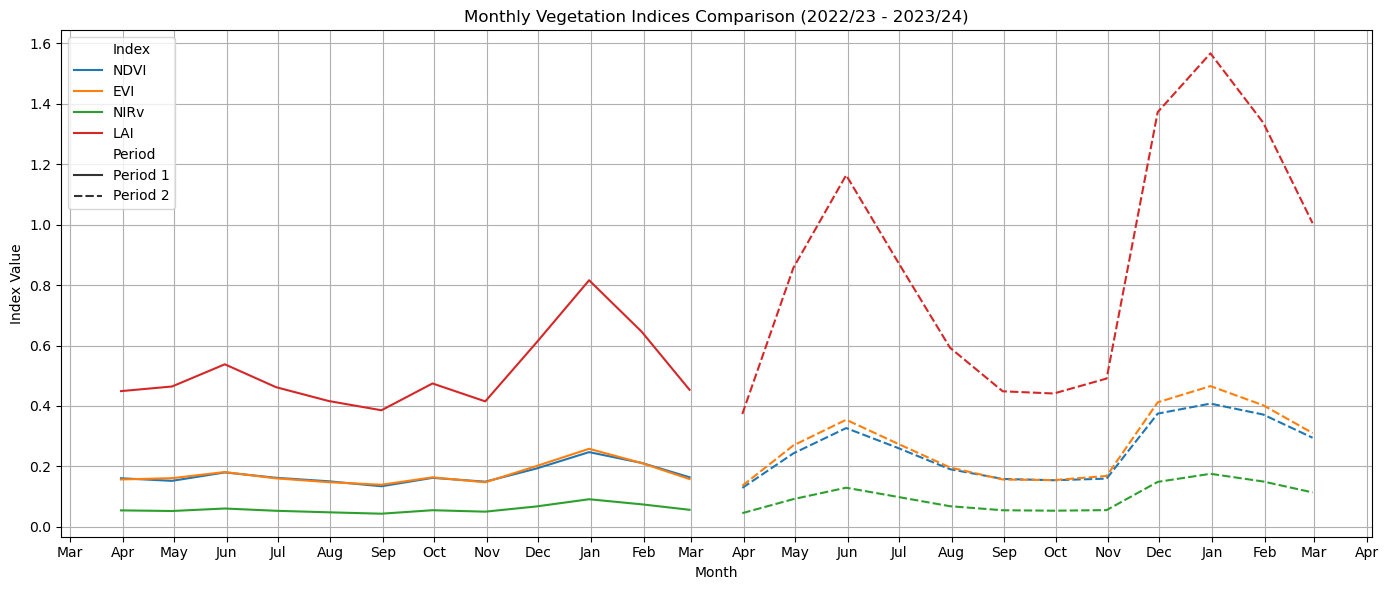

In [192]:
plot_monthly_indices_comparison(p1_indices, p2_indices)

In [ ]:
def detect_phenology(df, threshold_frac=0.2, absolute_thresholds=None):
    """
    Detects onset, offset, and duration of the growing season for each vegetation index
    using a hybrid of relative and absolute thresholds.

    Parameters:
        df (pd.DataFrame): Must contain 'time', 'Index', and 'Value' columns.
        threshold_frac (float): Fraction of amplitude used to define relative threshold.
        absolute_thresholds (dict): Optional. Dictionary of minimum absolute thresholds per index.

    Returns:
        pd.DataFrame: Summary table with onset date, offset date, duration in months, and threshold used.
    """
    if absolute_thresholds is None:
        absolute_thresholds = {}

    phenology_results = []

    for index in df['Index'].unique():
        subset = df[df['Index'] == index].sort_values('time')
        values = subset['Value'].to_numpy()
        dates = pd.to_datetime(subset['time']).to_numpy()

        min_val = np.min(values)
        max_val = np.max(values)
        amplitude = max_val - min_val
        relative_threshold = min_val + threshold_frac * amplitude
        abs_threshold = absolute_thresholds.get(index, 0.0)

        # Use the higher of the relative or absolute threshold
        threshold = max(relative_threshold, abs_threshold)

        # Onset: first time value crosses threshold
        onset_idx = np.argmax(values >= threshold)
        onset_date = pd.Timestamp(dates[onset_idx]) if values[onset_idx] >= threshold else None

        # Offset: last time value crosses threshold (from the end)
        offset_idx = len(values) - np.argmax(values[::-1] >= threshold) - 1
        offset_date = pd.Timestamp(dates[offset_idx]) if values[offset_idx] >= threshold else None

        # Duration in months
        if onset_date and offset_date:
            duration = (offset_date.year - onset_date.year) * 12 + (offset_date.month - onset_date.month)
        else:
            duration = None

        phenology_results.append({
            'Index': index,
            'Onset_Date': onset_date,
            'Offset_Date': offset_date,
            'Duration_Months': round(duration, 1) if duration is not None else None,
            'Threshold_Value': round(threshold, 4)
        })

    return pd.DataFrame(phenology_results)

In [186]:
absolute_thresholds = {
    'NDVI': 0.2,
    'EVI': 0.1,
    'NIRv': 0.05,
    'LAI': 0.5
}

detect_phenology(p1_indices, threshold_frac=0.2, absolute_thresholds=absolute_thresholds)

,Index,Onset_Date,Offset_Date,Duration_Months,Threshold_Value
0,NDVI,2022-12-31,2023-01-31,1,0.200
1,EVI,2022-05-31,2023-01-31,8,0.163
2,NIRv,2022-03-31,2023-02-28,11,0.053
3,LAI,2022-05-31,2023-01-31,8,0.500


In [188]:
detect_phenology(p2_indices, threshold_frac=0.2, absolute_thresholds=absolute_thresholds)

,Index,Onset_Date,Offset_Date,Duration_Months,Threshold_Value
0,NDVI,2023-04-30,2024-02-29,10,0.2000
1,EVI,2023-04-30,2024-02-29,10,0.2018
2,NIRv,2023-04-30,2024-02-29,10,0.0713
3,LAI,2023-04-30,2024-02-29,10,0.6122


In [165]:
def plot_indices_with_rainfall(indices_df, precip_df, period_label):
    """
    Plots vegetation indices on the primary y-axis and precipitation on a secondary y-axis.

    Parameters:
    - indices_df: tidy DataFrame with ['time', 'Index', 'Value']
    - precip_df: DataFrame with ['date', 'precip'] for the same period
    - period_label: string to label the time window (e.g. '2022–2023')
    """
    # Ensure datetime formats
    df = indices_df.copy()
    df['time'] = pd.to_datetime(df['time'])
    precip_df['date'] = pd.to_datetime(precip_df['date'])

    # Get unique colors for each index
    indices = df['Index'].unique()
    palette = dict(zip(indices, sns.color_palette("Set2", len(indices))))

    # Create plot with dual y-axes
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot vegetation indices
    for index in indices:
        subset = df[df['Index'] == index]
        ax1.plot(subset['time'], subset['Value'], label=index, color=palette[index])

    ax1.set_xlabel('Month')
    ax1.set_ylabel('Vegetation Index Value')
    ax1.set_title(f'Monthly Vegetation Indices and Daily Rainfall\nStudy Area ({period_label})')
    ax1.grid(True)

    # Format x-axis ticks
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    # Add precipitation on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(precip_df['date'], precip_df['precip'], color='blue', alpha=0.3, label='Precipitation')
    ax2.set_ylabel('Precipitation (mm)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.tight_layout()
    plt.show()

In [166]:
def feature_collection_to_precip_df(fc):
    """ 
    Converts a daily precipitation FeatureCollection to a pandas DataFrame.

    Parameters:
    - fc: ee.FeatureCollection with 'date' and 'precip' properties

    Returns:
    - DataFrame with ['date', 'precip']
     """
    features = fc.getInfo()['features']
    data = [{'date': f['properties']['date'], 'precip': f['properties']['precip']} for f in features]
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'])
    df['precip'] = pd.to_numeric(df['precip'], errors='coerce')
    return df

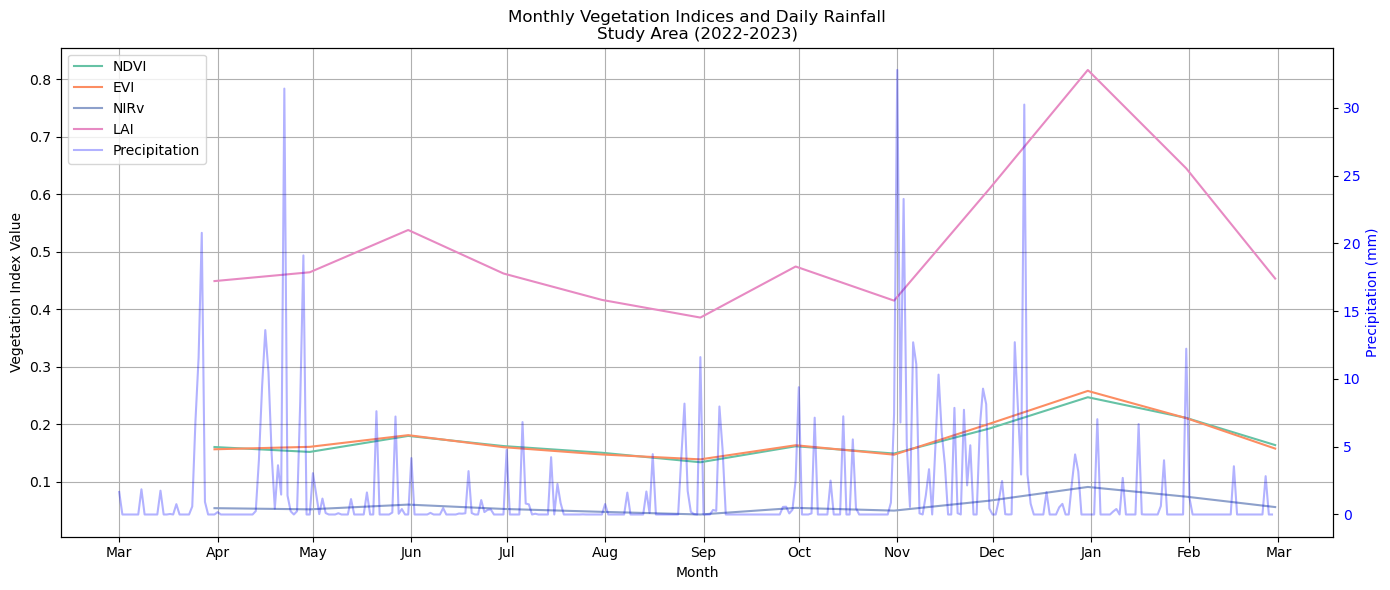

In [167]:
p1_precip_df = feature_collection_to_precip_df(daily_precip_fc_p1)
plot_indices_with_rainfall(p1_indices, p1_precip_df, '2022-2023')

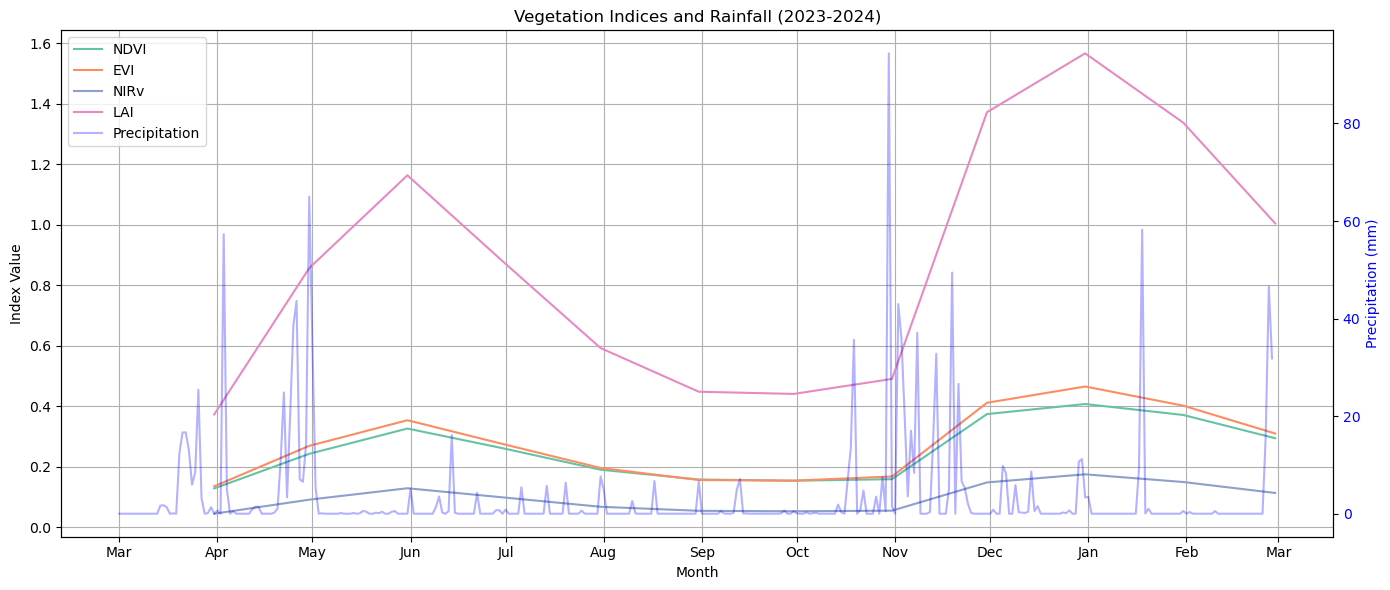

In [155]:
p2_precip_df = feature_collection_to_precip_df(daily_precip_fc_p2)
plot_indices_with_rainfall(p2_indices, p2_precip_df, '2023-2024')